# Infering launch parameters from cannon trajectories
![Canon trajectories](cannon.png)

A cannon launches cannonballs starting from a random distribution of initial velocities and launch angles.  Can we figure out the distributions of these two quantities only by observing some number of launch trajectories?  To make things even more challenging, we observe the trajectories imperfectly, with measurement error represented as white noise.

This is a statistical inference problem where we will work from a description of the problem as a system of Ordinary Differential Equations (ODEs).  We are then working with a stochastic ODE -- an ODE where some of the parameters are probability distributions, instead of deterministic values.  The basic idea of inference here is then:
1. Setup a model for the system.  We will consider an analytic model (we choose the ODEs) and a machine learning approach where the ODEs are represented by a neural network.
2. Convert the deterministic ODE to a stochastic ODE by converting parameters to distributions and adding in white noise.
3. Assign some prior distributions to all the statistical parameters, representing any prior knowledge we have in the system response.  Here we use uninformed priors which don't contain much additional info.
4. Simulate the distribution of trajectories from the current statistical model.  Compare this distribution to the distribution of the actual trajectories we observed.
5. Update the distributions to make the simulated and observed trajectory distributions more similar.

The difficulty is in #4 and #5.

In simulating the model response we need to integrate the stochastic ODE through time to give some sampled cannonball trajectories.  The trick here is that we need this integration to be differentiable -- our method for updating the distributions to better match the data will require the gradient of the response with respect to those parameters.  We implement differentiable ODE integration using the adjoint approach, as implemented in the `ode` module of this library.  In addition, we vectorize the time integration -- both the forward simulations and the backward adjoint pass -- to decrease the time required to run each iteration.

We will use an approach called Stochastic Variational Inference (as implemted in *pyro*) to do the Bayesian update.  (More text here)

In [1]:
# Import modules
import torch
from functorch import vmap, jacfwd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyoptmat import ode
import matplotlib.pyplot as plt
import pyro.distributions.constraints as constraints
import pyro.optim as optim
from tqdm.notebook import tqdm

## Setup how to solve ODEs

These are general `torch` options controlling how we run the problem:
1. We are going to use double precision arithmetic.  This isn't actually necessary here, but often is required for more sophisticated ODEs representing physical systems.
2. We run all the math on a GPU, if available.

The `nchunk` option controls how many time steps during the integration step are vectorized -- solved  simultaneously on the GPU.  The optimal `nchunk` will vary based on your system, but these are simple ODEs and large chunk sizes are often pretty effective.

In [2]:
# How to setup and solve odes
# Use doubles
torch.set_default_tensor_type(torch.DoubleTensor)

# Run on GPU!
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

# Parallel time steps
nchunk = 50

## Define an analytic ODE model

We are going to use this analytic model to both generate the "data" -- the set of observed trajectories we're going to use to train the statistical models -- as well as use the same analytic model as an example of an infered model.  The idea of using the same model for both is we can check on our results -- ideally the process will recover the same statistical distributions for the launch angle and velocity as we put in to generate the synthetic "data".

This model is pretty simple.  It is a system of two coupled ODEs representing the $x$ and $y$ positions of the cannonball:
$$\begin{bmatrix}
\dot{x}\\ 
\dot{y}
\end{bmatrix} = \begin{bmatrix}
v \cos{a}\\ 
v \sin{a} - gt
\end{bmatrix}$$
where $a$ is the launch angle, $v$ is the launch velocity, $g$ is the gravitional acceleration, and $t$ is time.

We need to provide not only the time rate of change ($\dot{y}$) but also the Jacobian of the rate of change with respect to the problem state ($\frac{d \dot{y}}{dy}$).  The reason is that `pyoptmat` uses *implicit* time integration techniques, that solve a nonlinear system to update the problem state through time.  These approaches in turn use Newton's method to solve these nonlinear equations and Newton's method requires this Jacobian for optimal convergence.  Here we get the Jacobian using torch automatic differentiation, vectorized with the `functorch` tools. 

In [3]:
# Define the ODE
class IdealTrajectory(torch.nn.Module):
    """ODE describing an ideal parabolic trajectory
    
    Args:
        v (torch.tensor): initial velocity
        a (torch.tensor): launch angle
        g (torch.tensor): gravitational acceleration
    """
    def __init__(self, v, a, g):
        super().__init__()
        
        self.v = v
        self.a = a
        
        self.g = g
        
    def force(self, t, g):
        """Defines the driving force, here gravity
        
        Args:
            t (torch.tensor): current time
            g (torch.tensor): gravitational acceleration
        """
        f = torch.zeros(t.shape + (2,), device = t.device)
        f[...,1] = -g * t
        
        return f
        
    def rate(self, t, y, f, v, a):
        """Defines y_dot, here the rate of change in x and y position
        
        Args:
            t (torch.tensor): current time
            y (torch.tensor): current [x,y] position
            f (torch.tensor): gravitational force
            v (torch.tensor): initial velocity
            a (torch.tensor): initial angle
        """
        y_dot = torch.empty_like(y)
        
        y_dot[...,0] = v * torch.cos(a)
        y_dot[...,1] = v * torch.sin(a)
        
        return y_dot + f    
    
    def forward(self, t, y):
        """Defines y_dot and d_y_dot_d_y, here with AD
        
        Args:
            t (torch.tensor): current time
            y (torch.tensor): current state
        """
        f = self.force(t, self.g)
        y_dot = self.rate(t, y, f, self.v.unsqueeze(0).expand(t.shape), self.a.unsqueeze(0).expand(t.shape))
        
        J = vmap(vmap(jacfwd(self.rate, argnums = 1)))(t, y, f, self.v.unsqueeze(0).expand(t.shape), self.a.unsqueeze(0).expand(t.shape))
        
        return y_dot, J

## Setup a stochastic ODE model
The model we just set up is deterministic, we need a statistical model both to sample from to get our training trajectories and then to use to fit in the SVI process.  We can use `pyro` to convert this deterministic ODE to a statistical model.

We want a specific type of statistical model though, a Hierarchical Bayesian model.  The idea here we want to sample the model parameters twice -- first to determine the location and scale of the launch angle and velocity distributions, and then again from those sampled locations and scales to determine the actual launch angle and velocity for each individual trial.  We will assume that the actual launch angles and velocities follow a normal distribution with true location and scale given at the top of this cell.  We also set the true level of white noise and the gravitational acceleration.

After setting up these true posteriors, we then use `pyro` to formulate a hierarchical model.  We'll use this model first to generate the input data -- some set of observed trajectories -- as well as later to infer an analytic statistical model starting from some uninformed prior distributions, which aren't all that close to the true posteriors.

In [4]:
# Setup the true model posterior, so we can check how well we did later
v_loc_true = 2.0
v_scale_true = 0.03
a_loc_true = 0.7
a_scale_true = 0.04
eps_true = 0.1

# This is the key function: given the parameters we want to infer, integrate a time series
def hierarchical_statistical_model(times, 
                                   results = None,
                                   v_loc = dist.Delta(torch.tensor(v_loc_true, device = device)),
                                   v_scale = dist.Delta(torch.tensor(v_scale_true, device = device)),
                                   a_loc = dist.Delta(torch.tensor(a_loc_true, device = device)),
                                   a_scale = dist.Delta(torch.tensor(a_scale_true, device = device)),
                                   eps = dist.Delta(torch.tensor(eps_true, device = device)),
                                   g = torch.tensor(0.1, device = device),
                                   track_backward = []):
    """
    Args:
        times (torch.tensor): time points to observe
        
    Keyword Args:
        results (torch.tensor): if provided, data to condition on
        v_loc (pyro.distribution): prior distribution for the mean velocity
        v_scale (pyro.distribution): prior distribution for the std. dev. of the velocity
        a_loc (pyro.distribution): prior distribution for the mean launch angle
        a_scale (pyro.distribution): prior distribution for the std. dev. of the launch angle
        eps (pyro.distribution): prior distribution for the level of white noise
        g (torch.tensor): gravitational acceleration
        track_backward (list of parameters): pyro parameters to track in the adjoint pass
    """
    # Setup initial conditions
    y0 = torch.zeros((times.shape[-1],) + (2,), device = times.device)
    
    # Sample the top-level parameters
    v_loc = pyro.sample("v_loc", v_loc)
    v_scale = pyro.sample("v_scale", v_scale)
    a_loc = pyro.sample("a_loc", a_loc)
    a_scale = pyro.sample("a_scale", a_scale)
    eps = pyro.sample("eps", eps)
    
    with pyro.plate("trials", times.shape[1]):
        # Sample the bottom level parameters
        v = pyro.sample("v", dist.Normal(v_loc, v_scale))
        a = pyro.sample("a", dist.Normal(a_loc, a_scale))
        
        # Setup the model with the sampled parameters
        ode_model = IdealTrajectory(v, a, g)
        
        # Integrate in time...
        res = ode.odeint_adjoint(ode_model, y0, times, block_size = nchunk, extra_params = track_backward)
        
        # plate in time
        with pyro.plate("time", times.shape[0]):
            # Add the noise
            with_noise = pyro.sample("obs", dist.Normal(res, eps).to_event(1), obs = results)
            
    return with_noise

Text(0, 0.5, 'y')

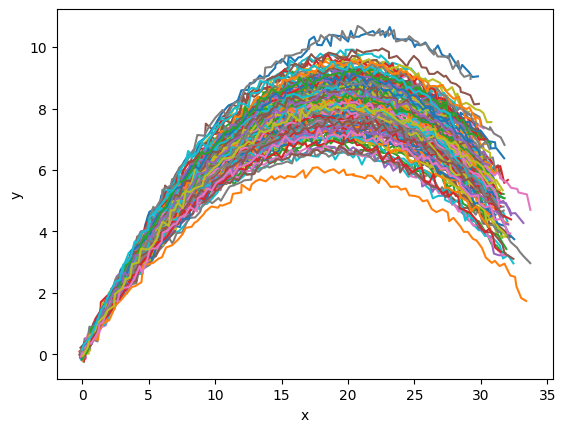

In [5]:
# Sample some "data" to infer back with
nsamples = 150
ntime = 100
tmax = 20.0

times = torch.linspace(0, tmax, ntime, device = device).unsqueeze(-1).expand(ntime, nsamples)
data = hierarchical_statistical_model(times)

plt.plot(data.to("cpu")[...,0], data.to("cpu")[...,1])
plt.xlabel("x")
plt.ylabel("y")

In [6]:
# Okay, now let's try to re-infer the distribution of the launch velocity and angle
# First clear any parameters we've setup
pyro.clear_param_store()
# It would be unfair to start from the true posterior, instead assign prior guesses on the parameters
v_loc_prior = torch.tensor(1.5, device = device)
v_scale_prior = torch.tensor(0.1, device = device)
a_loc_prior = torch.tensor(0.3, device = device)
a_scale_prior = torch.tensor(0.1, device = device)
eps_prior = torch.tensor(0.05, device = device)

# Now we need to setup a "guide" function that mirrors the model but parameterizes the posteriors with
# analytic PDFs.  Here we use "Delta" distributions, giving a MAP estimate of the parameters
# There is also some aggrevation in that we need to track the model parameters for the adjoint pass through the integrator
def guide(times, results = None):
    # We need to track these explicitly for the adjoint pass
    v_loc_param = pyro.param("v_loc_param", v_loc_prior)
    v_scale_param = pyro.param("v_scale_param", v_scale_prior, constraint = constraints.positive)
    a_loc_param = pyro.param("a_loc_param", a_loc_prior)
    a_scale_param = pyro.param("a_scale_param", a_scale_prior, constraint = constraints.positive)
    eps_param = pyro.param("eps_param", eps_prior, constraint = constraints.positive)
    
    # Sample the top-level parameters
    v_loc = pyro.sample("v_loc", dist.Delta(v_loc_param))
    v_scale = pyro.sample("v_scale", dist.Delta(v_scale_param))
    a_loc = pyro.sample("a_loc", dist.Delta(a_loc_param))
    a_scale = pyro.sample("a_scale", dist.Delta(a_scale_param))
    eps = pyro.sample("eps", dist.Delta(eps_param))
    
    with pyro.plate("trials", times.shape[1]):
        # Sample the bottom level parameters
        v_param = pyro.param("v_param", torch.ones(times.shape[1], device = times.device)*1.5)
        a_param = pyro.param("a_param", torch.ones(times.shape[1], device = times.device)*0.1)
        
        v = pyro.sample("v", dist.Delta(v_param))
        a = pyro.sample("a", dist.Delta(a_param))

# This sets up the parameter store
guide(times)
# We need to track these on the backward pass
track_params = [pyro.param("v_param").unconstrained(), pyro.param("a_param").unconstrained()]
# Make sure we set the priors and the extra tracked parameters
infer_model = lambda times, results = None: hierarchical_statistical_model(times, results = results, 
                                                           v_loc = dist.Normal(v_loc_prior, v_scale_prior),
                                                           v_scale = dist.HalfNormal(v_scale_prior),
                                                           a_loc = dist.Normal(a_loc_prior, a_scale_prior),
                                                           a_scale = dist.HalfNormal(a_scale_prior),
                                                           eps = dist.HalfNormal(eps_prior),
                                                           track_backward = track_params)

Text(0, 0.5, 'y')

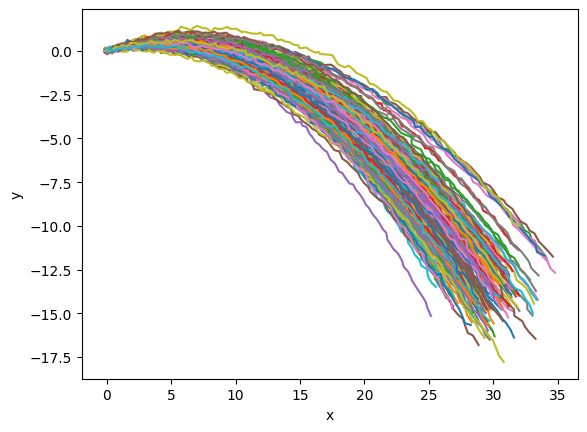

In [7]:
# Prove we're starting from somewhere different...
prior_samples = infer_model(times)
plt.plot(prior_samples.detach().to("cpu")[...,0], prior_samples.detach().to("cpu")[...,1])
plt.xlabel("x")
plt.ylabel("y")

In [8]:
# Finally, the interesting bit.  Let's try to infer the launch angles and velocities
# Optimization options
lr = 5.0e-3 # Learning rate
niter = 250 # Number of Adam iterations
num_samples = 1 # Number of samples in computing the ELBO

# Use clipped adam
optimizer = optim.ClippedAdam({"lr": lr})
# Setup the ELBO loss
l = Trace_ELBO(num_particles=num_samples)
svi = SVI(infer_model, guide, optimizer, loss = l)

loss_hist = []
t = tqdm(range(niter))
for i in t:
    loss = svi.step(times, data)
    loss_hist.append(loss)
    t.set_description("Loss: %3.2e" % loss)

  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy check (infered/true)
Velocity loc: 2.005/2.000
Velocity scale: 0.030/0.030
Angle loc: 0.701/0.700
Angle scale: 0.040/0.040
White noise: 0.100/0.100


Text(0, 0.5, 'ELBO')

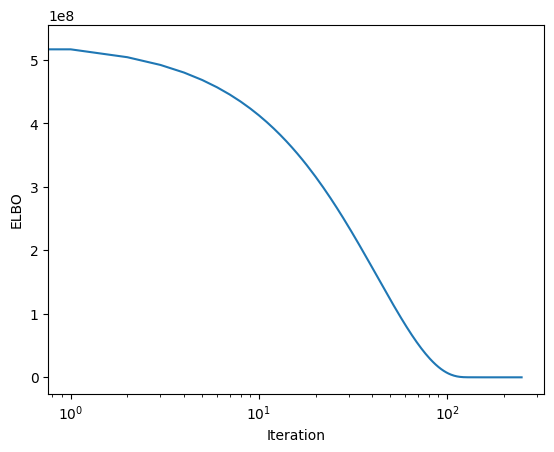

In [9]:
# Now check how well we did
print("Accuracy check (infered/true)")
print("Velocity loc: %4.3f/%4.3f" % (pyro.param("v_loc_param").data, v_loc_true))
print("Velocity scale: %4.3f/%4.3f" % (pyro.param("v_scale_param").data, v_scale_true))
print("Angle loc: %4.3f/%4.3f" % (pyro.param("a_loc_param").data, a_loc_true))
print("Angle scale: %4.3f/%4.3f" % (pyro.param("a_scale_param").data, a_scale_true))
print("White noise: %4.3f/%4.3f" % (pyro.param("eps_param").data, eps_true))

# And the loss plot
plt.semilogx(loss_hist)
plt.xlabel("Iteration")
plt.ylabel("ELBO")

Text(0, 0.5, 'y position')

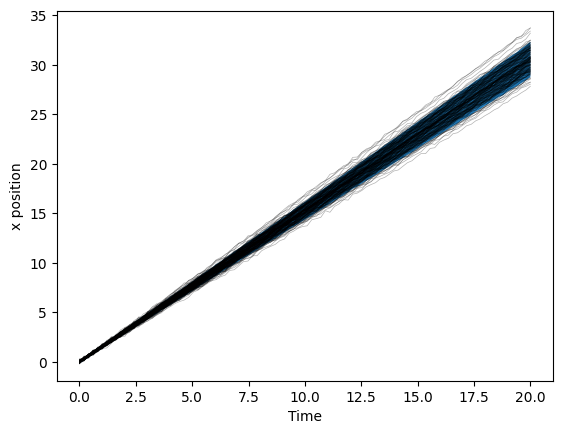

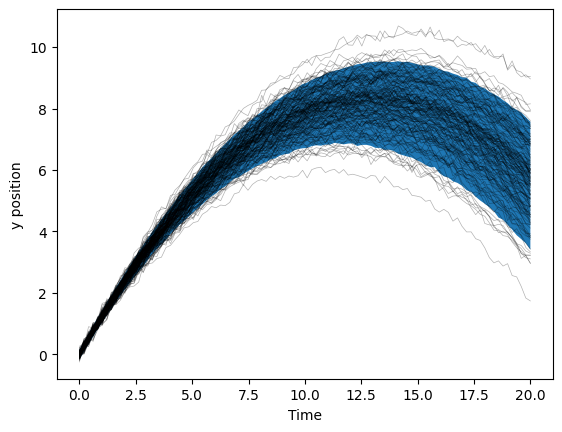

In [10]:
# And we can sample from the infered posterior
N = 10
predict = Predictive(infer_model, guide=guide, num_samples=N, return_sites=("obs",))
samples_from_infered =  predict(times)["obs"].transpose(0,1).reshape(ntime,-1,2)

# Calculate a 90% confidence interval
p = 0.05
nlow = int(p*samples_from_infered.shape[1])
nhigh = int((1-p) * samples_from_infered.shape[1])
lb, _ = torch.kthvalue(samples_from_infered, nlow, dim = 1)
ub, _ = torch.kthvalue(samples_from_infered, nhigh, dim = 1)
plt.figure()
plt.plot(times.cpu(), data[...,0].cpu(), color = 'k', lw = 0.5, alpha = 0.3)
plt.fill_between(times[:,0].cpu(), lb[...,0].cpu(), ub[...,0].cpu())
plt.xlabel("Time")
plt.ylabel("x position")

plt.figure()
plt.plot(times.cpu(), data[...,1].cpu(), color = 'k', lw = 0.5, alpha = 0.3)
plt.fill_between(times[:,0].cpu(), lb[...,1].cpu(), ub[...,1].cpu())
plt.xlabel("Time")
plt.ylabel("y position")

In [20]:
# But what if we don't know we're observing canon trajectories?  Can we train a neural ODE to capture the data?

# Useful to do multibatch matrix-vector products
def mbmm(A, B):
    return torch.einsum('...ik,...k->...i', A, B)

# Well, let's try.  First setup the neural ODE
# Define the ODE
class NeuralTrajectory(torch.nn.Module):
    """ODE describing an ideal parabolic trajectory
    
    Args:
        v (torch.tensor): initial velocity
        a (torch.tensor): launch angle
        g (torch.tensor): gravitational acceleration
    """
    def __init__(self, w_in, b_in, w_hidden, b_hidden, w_out, b_out, g,
                activation = torch.nn.ReLU()):
        super().__init__()
        
        self.w_in = w_in
        self.b_in = b_in
        self.w_hidden = w_hidden
        self.b_hidden = b_hidden
        self.w_out = w_out
        self.b_out = b_out
        
        self.g = g
        
        self.activation = activation
        
    def force(self, t, g):
        """Defines the driving force, here gravity
        
        Args:
            t (torch.tensor): current time
            g (torch.tensor): gravitational acceleration
        """
        f = torch.zeros(t.shape + (2,), device = t.device)
        f[...,1] = -g * t
        
        return f
        
    def rate(self, t, y, f, w_in, b_in, w_hidden, b_hidden, w_out, b_out):
        """Defines y_dot, here the rate of change in x and y position
        
        Args:
            t (torch.tensor): current time
            y (torch.tensor): current [x,y] position
            f (torch.tensor): gravitational force
            v (torch.tensor): initial velocity
            a (torch.tensor): initial angle
        """
        y_dot = torch.empty_like(y)
        
        inp = torch.cat((y, f), -1)
        
        y_dot = self.activation(mbmm(w_in, inp) + b_in)
        
        for i in range(w_hidden.shape[-1]):
            y_dot = self.activation(mbmm(w_hidden[...,i], y_dot) + b_hidden[...,i])
        
        y_dot = mbmm(w_out, y_dot) + b_out
                
        return y_dot
    
    def _expand(self, t, p):
        return p.unsqueeze(0).expand(t.shape + p.shape[1:])
    
    def forward(self, t, y):
        """Defines y_dot and d_y_dot_d_y, here with AD
        
        Args:
            t (torch.tensor): current time
            y (torch.tensor): current state
        """
        f = self.force(t, self.g)
        y_dot = self.rate(t, y, f, 
                          self._expand(t, self.w_in), self._expand(t, self.b_in),
                          self._expand(t, self.w_hidden), self._expand(t, self.b_hidden),
                          self._expand(t, self.w_out), self._expand(t, self.b_out))
        
        J = vmap(vmap(jacfwd(self.rate, argnums = 1)))(t, y, f, 
                                                       self._expand(t, self.w_in), self._expand(t, self.b_in),
                                                       self._expand(t, self.w_hidden), self._expand(t, self.b_hidden),
                                                       self._expand(t, self.w_out), self._expand(t, self.b_out))
        
        return y_dot, J

In [39]:
# Make sure we're clear
pyro.clear_param_store()

# We can go right into the model for inference, we already have the true data
size_in = 2 + 2
n_hidden = 2
size_hidden = 4
size_out = 2

# Some rough magnitudes for the weight and bias values
w_mag = 0.1
b_mag= 0.1
var_fac = 10.0

def nn_model(times, results = None, track_backward = []):
    """
    Args:
        times (torch.tensor): time points to observe
    """
    # Setup initial conditions
    y0 = torch.zeros((times.shape[-1],) + (2,), device = times.device)
    
    # Sample the top-level parameters
    w_in_loc = pyro.sample("w_in_loc", dist.Normal(torch.rand(size_hidden,size_in, device = times.device)*w_mag, 
                                                  torch.rand(size_hidden,size_in, device = times.device)*w_mag/var_fac).to_event(2))
    w_in_scale = pyro.sample("w_in_scale", dist.HalfNormal(torch.rand(size_hidden,size_in, device = times.device)*w_mag/var_fac).to_event(2))
    b_in_loc = pyro.sample("b_in_loc", dist.Normal(torch.rand(size_hidden, device = times.device)*b_mag, 
                                                  torch.rand(size_hidden, device = times.device)*b_mag/var_fac).to_event(1))
    b_in_scale = pyro.sample("b_in_scale", dist.HalfNormal(torch.rand(size_hidden, device = times.device)*b_mag/var_fac).to_event(1))
    
    w_hidden_loc = pyro.sample("w_hidden_loc", dist.Normal(torch.rand(size_hidden,size_hidden,n_hidden, device = times.device)*w_mag, 
                                                  torch.rand(size_hidden,size_hidden,n_hidden, device = times.device)*w_mag/var_fac).to_event(3))
    w_hidden_scale = pyro.sample("w_hidden_scale", dist.HalfNormal(torch.rand(size_hidden,size_hidden, n_hidden, device = times.device)*w_mag/var_fac).to_event(3))
    b_hidden_loc = pyro.sample("b_hidden_loc", dist.Normal(torch.rand(size_hidden, n_hidden, device = times.device)*b_mag, 
                                                  torch.ones(size_hidden, n_hidden, device = times.device)*b_mag/var_fac).to_event(2))
    b_hidden_scale = pyro.sample("b_hidden_scale", dist.HalfNormal(torch.rand(size_hidden, n_hidden, device = times.device)*b_mag/var_fac).to_event(2))
    
    w_out_loc = pyro.sample("w_out_loc", dist.Normal(torch.rand(size_out,size_hidden, device = times.device), 
                                                  torch.rand(size_out,size_hidden, device = times.device)*w_mag).to_event(2))
    w_out_scale = pyro.sample("w_out_scale", dist.HalfNormal(torch.rand(size_out,size_hidden, device = times.device)*w_mag/var_fac).to_event(2))
    b_out_loc = pyro.sample("b_out_loc", dist.Normal(torch.ones(size_out, device = times.device)*w_mag/var_fac, 
                                                  torch.ones(size_out, device = times.device)*b_mag).to_event(1))
    b_out_scale = pyro.sample("b_out_scale", dist.HalfNormal(torch.ones(size_out, device = times.device)*b_mag/var_fac).to_event(1))
    
    eps = pyro.sample("eps", dist.HalfNormal(torch.tensor(0.05, device = times.device)))
    
    with pyro.plate("trials", times.shape[1]):
        # Sample the bottom level parameters
        w_in = pyro.sample("w_in", dist.Normal(w_in_loc, w_in_scale).to_event(2))
        b_in = pyro.sample("b_in", dist.Normal(b_in_loc, b_in_scale).to_event(1))
        
        w_hidden = pyro.sample("w_hidden", dist.Normal(w_hidden_loc, w_hidden_scale).to_event(3))
        b_hidden = pyro.sample("b_hidden", dist.Normal(b_hidden_loc, b_hidden_scale).to_event(2))
        
        w_out = pyro.sample("w_out", dist.Normal(w_out_loc, w_out_scale).to_event(2))
        b_out = pyro.sample("b_out", dist.Normal(b_out_loc, b_out_scale).to_event(1))
        
        # Setup the model with the sampled parameters
        ode_model = NeuralTrajectory(w_in, b_in, w_hidden, b_hidden, w_out, b_out, torch.tensor(0.1, device = device))
                
        # Integrate in time...
        res = ode.odeint_adjoint(ode_model, y0, times, block_size = nchunk, extra_params = track_backward)
        
        # plate in time
        with pyro.plate("time", times.shape[0]):
            # Add the noise
            with_noise = pyro.sample("obs", dist.Normal(res, eps).to_event(1), obs = results)
    
    return with_noise

# The guide really mimics the model now
def nn_guide(times, results = None):
    # Parameters
    w_in_loc_param = pyro.param("w_in_loc_param", torch.rand(size_hidden,size_in, device = times.device)*w_mag)
    w_in_scale_param = pyro.param("w_in_scale_param", torch.rand(size_hidden,size_in, device = times.device)*w_mag/var_fac, constraint = constraints.positive)
    b_in_loc_param = pyro.param("b_in_loc_param", torch.rand(size_hidden, device = times.device)*b_mag)
    b_in_scale_param = pyro.param("b_in_scale_param", torch.rand(size_hidden,device = times.device)*b_mag/var_fac, constraint = constraints.positive)
    
    w_hidden_loc_param = pyro.param("w_hidden_loc_param", torch.rand(size_hidden,size_hidden, n_hidden, device = times.device)*w_mag)
    w_hidden_scale_param = pyro.param("w_hidden_scale_param", torch.rand(size_hidden,size_hidden, n_hidden, device = times.device)*w_mag/var_fac, constraint = constraints.positive)
    b_hidden_loc_param = pyro.param("b_hidden_loc_param", torch.rand(size_hidden, n_hidden, device = times.device)*b_mag)
    b_hidden_scale_param = pyro.param("b_hidden_scale_param", torch.rand(size_hidden, n_hidden, device = times.device)*b_mag/var_fac, constraint = constraints.positive)
    
    w_out_loc_param = pyro.param("w_out_loc_param", torch.rand(size_out,size_hidden, device = times.device)*w_mag)
    w_out_scale_param = pyro.param("w_out_scale_param", torch.rand(size_out,size_hidden, device = times.device)*w_mag/var_fac, constraint = constraints.positive)
    b_out_loc_param = pyro.param("b_out_loc_param", torch.rand(size_out, device = times.device)*b_mag)
    b_out_scale_param = pyro.param("b_out_scale_param", torch.rand(size_out,device = times.device)*b_mag/var_fac, constraint = constraints.positive)
    
    eps_param = pyro.param("eps_param", torch.tensor(0.05, device = device), constraint = constraints.positive)
    
    # Sample the top-level parameters
    w_in_loc = pyro.sample("w_in_loc", dist.Delta(w_in_loc_param).to_event(2))
    w_in_scale = pyro.sample("w_in_scale", dist.Delta(w_in_scale_param).to_event(2))
    b_in_loc = pyro.sample("b_in_loc", dist.Delta(b_in_loc_param).to_event(1))
    b_in_scale = pyro.sample("b_in_scale", dist.Delta(b_in_scale_param).to_event(1))
        
    w_hidden_loc = pyro.sample("w_hidden_loc", dist.Delta(w_hidden_loc_param).to_event(3))
    w_hidden_scale = pyro.sample("w_hidden_scale", dist.Delta(w_hidden_scale_param).to_event(3))
    b_hidden_loc = pyro.sample("b_hidden_loc", dist.Delta(b_hidden_loc_param).to_event(2))
    b_hidden_scale = pyro.sample("b_hidden_scale", dist.Delta(b_hidden_scale_param).to_event(2))
    
    w_out_loc = pyro.sample("w_out_loc", dist.Delta(w_out_loc_param).to_event(2))
    w_out_scale = pyro.sample("w_out_scale", dist.Delta(w_out_scale_param).to_event(2))
    b_out_loc = pyro.sample("b_out_loc", dist.Delta(b_out_loc_param).to_event(1))
    b_out_scale = pyro.sample("b_out_scale", dist.Delta(b_out_scale_param).to_event(1))
    
    eps = pyro.sample("eps", dist.Delta(eps_param))
    
    with pyro.plate("trials", times.shape[1]):
        # Setup the bottom level parameters
        w_in_param = pyro.param("w_in_param", torch.rand(times.shape[1], size_hidden, size_in, device = times.device) * w_mag)
        b_in_param = pyro.param("b_in_param", torch.rand(times.shape[1], size_hidden, device = times.device) * b_mag)
        
        w_hidden_param = pyro.param("w_hidden_param", torch.rand(times.shape[1], size_hidden, size_hidden, n_hidden, device = times.device) * w_mag)
        b_hidden_param = pyro.param("b_hidden_param", torch.rand(times.shape[1], size_hidden, n_hidden, device = times.device) * b_mag)
        
        w_out_param = pyro.param("w_out_param", torch.rand(times.shape[1], size_out, size_hidden, device = times.device) * w_mag)
        b_out_param = pyro.param("b_out_param", torch.rand(times.shape[1], size_out, device = times.device) * b_mag)
        
        w_in = pyro.sample("w_in", dist.Delta(w_in_param).to_event(2))
        b_in = pyro.sample("b_in", dist.Delta(b_in_param).to_event(1))
        
        w_hidden = pyro.sample("w_hidden", dist.Delta(w_hidden_param).to_event(3))
        b_hidden = pyro.sample("b_hidden", dist.Delta(b_hidden_param).to_event(2))
        
        w_out = pyro.sample("w_out", dist.Delta(w_out_param).to_event(2))
        b_out = pyro.sample("b_out", dist.Delta(b_out_param).to_event(1))

# Setup the guide parameters
nn_guide(times)
        
# We need to track these on the backward pass
track_params = [pyro.param("w_in_param").unconstrained(), pyro.param("b_in_param").unconstrained(),
               pyro.param("w_hidden_param").unconstrained(), pyro.param("b_hidden_param").unconstrained(),
               pyro.param("w_out_param").unconstrained(), pyro.param("b_out_param").unconstrained()]
# Make sure we set the priors and the extra tracked parameters
tracked_nn_model = lambda times, results = None: nn_model(times, results = results, track_backward = track_params)

In [37]:
# Let's try to infer the model response!
lr = 1.0e-4 # Learning rate
niter = 5000 # Number of Adam iterations
num_samples = 1 # Number of samples in computing the ELBO

# Use clipped adam
optimizer = optim.ClippedAdam({"lr": lr})
# Setup the ELBO loss
l = Trace_ELBO(num_particles=num_samples)
svi = SVI(tracked_nn_model, nn_guide, optimizer, loss = l)

loss_hist = []
t = tqdm(range(niter))
for i in t:
    loss = svi.step(times, data)
    loss_hist.append(loss)
    t.set_description("Loss: %3.2e" % loss)

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0, 0.5, 'y position')

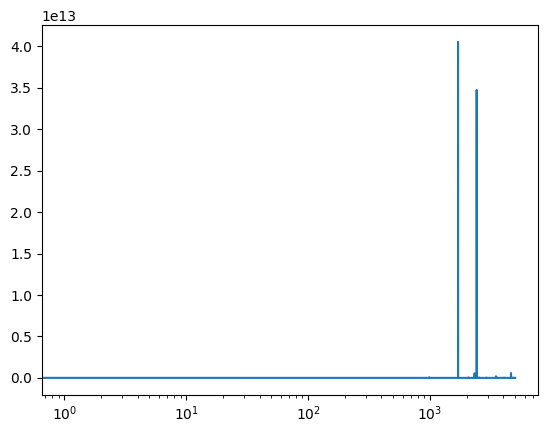

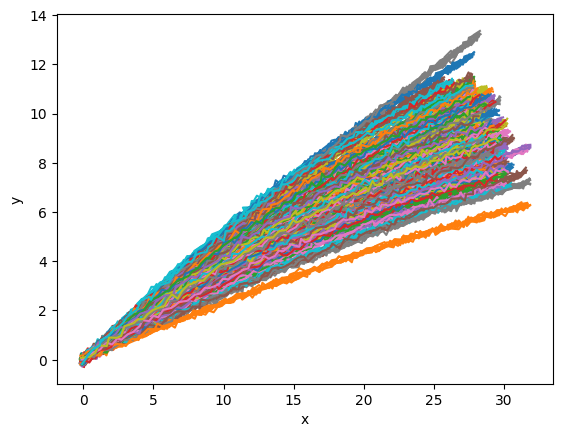

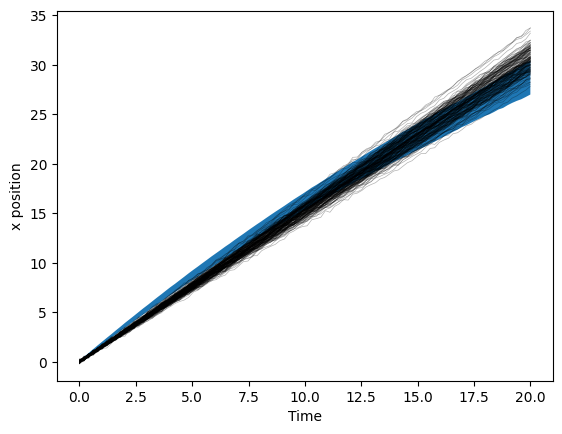

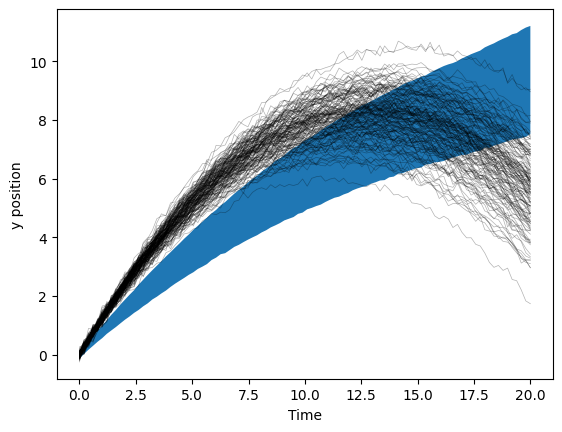

In [38]:
# See how well we did
# Plot the loss
plt.figure()
plt.semilogx(loss_hist)

# Take some samples
N = 10
predict = Predictive(tracked_nn_model, guide=nn_guide, num_samples=N, return_sites=("obs",))
samples_from_infered =  predict(times)["obs"].transpose(0,1).reshape(ntime,-1,2)

# Plot some samples...
plt.figure()
plt.plot(samples_from_infered[...,0].cpu(), samples_from_infered[...,1].cpu())
plt.xlabel("x")
plt.ylabel("y")

# Calculate a 90% confidence interval
p = 0.05
nlow = int(p*samples_from_infered.shape[1])
nhigh = int((1-p) * samples_from_infered.shape[1])
lb, _ = torch.kthvalue(samples_from_infered, nlow, dim = 1)
ub, _ = torch.kthvalue(samples_from_infered, nhigh, dim = 1)
plt.figure()
plt.plot(times.cpu(), data[...,0].cpu(), color = 'k', lw = 0.5, alpha = 0.3)
plt.fill_between(times[:,0].cpu(), lb[...,0].cpu(), ub[...,0].cpu())
plt.xlabel("Time")
plt.ylabel("x position")

plt.figure()
plt.plot(times.cpu(), data[...,1].cpu(), color = 'k', lw = 0.5, alpha = 0.3)
plt.fill_between(times[:,0].cpu(), lb[...,1].cpu(), ub[...,1].cpu())
plt.xlabel("Time")
plt.ylabel("y position")